# 💰 Projet Machine Learning Partie 2 : Prédiction du Prix (Régression)
**Module :** Machine Learning (M1 IA)
**Objectif :** Estimer le prix exact d'un ordinateur (en Euros) en fonction de sa configuration (RAM, CPU, GPU, etc.).

---

### 📋 Cycle de Vie du Projet
Nous allons adapter notre méthodologie au problème de régression (prédiction d'une valeur continue) :
1.  **Compréhension du problème :** Régression Supervisée (Target : `Price_euros`).
2.  **Collecte de données :** Réutilisation du dataset `laptop_prices.csv`.
3.  **Exploration (EDA) :** Étude de la distribution du prix (Log-Normale) et Matrice de Corrélation.
4.  **Prétraitement :** Nettoyage, Feature Engineering (PPI), Encodage (OneHot) et Normalisation.
5.  **Séparation :** Train / Test Split (85% / 15%).
6.  **Modélisation :** Comparaison de deux algorithmes :
    * *Régression Linéaire Multiple* (Standard).
    * *Régression Ridge* (Avec régularisation pour éviter le sur-apprentissage).
7.  **Évaluation :** Utilisation du score $R^2$ et de la MAE (Erreur Absolue Moyenne en €).
8.  **Déploiement :** Sauvegarde du meilleur modèle pour l'application Web.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('../data/laptop_prices.csv')

display(df.head(3))

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,...,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,...,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,...,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620


In [5]:
df['Ram'] = df['Ram'].astype(str).str.replace('GB', '').astype(int)
df['Weight'] = df['Weight'].astype(str).str.replace('kg', '').astype(float)

In [6]:
df['PPI'] = np.sqrt(df['ScreenW']**2 + df['ScreenH']**2) / df['Inches']

In [7]:
cols_to_drop = ['Inches', 'ScreenW', 'ScreenH', 'Product', 'Screen']
df_reg = df.drop(columns=cols_to_drop)

display(df_reg.head(2))

,Company,TypeName,Ram,OS,Weight,Price_euros,Touchscreen,IPSpanel,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model,PPI
0,Apple,Ultrabook,8,macOS,1.37,1339.69,No,Yes,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640,226.983005
1,Apple,Ultrabook,8,macOS,1.34,898.94,No,No,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000,127.677940


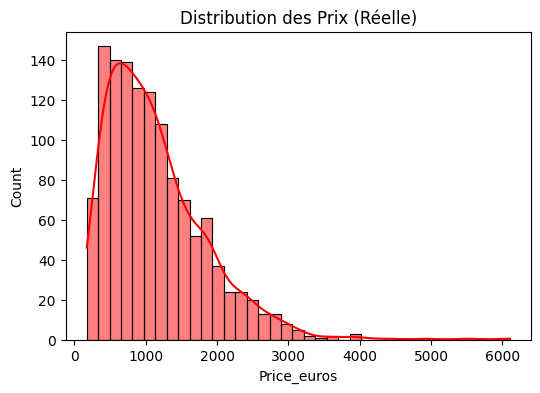

In [8]:
plt.figure(figsize=(6, 4))
sns.histplot(df_reg['Price_euros'], kde=True, color='red')
plt.title("Distribution des Prix (Réelle)")
plt.show()

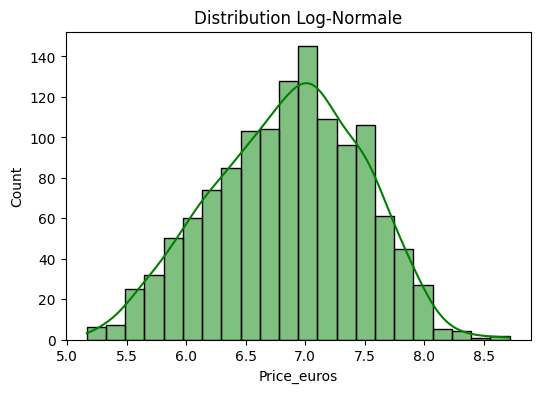

In [10]:
# On visualise ce que ça donne avec le Logarithme
plt.figure(figsize=(6, 4))
sns.histplot(np.log1p(df_reg['Price_euros']), kde=True, color='green')
plt.title("Distribution Log-Normale")
plt.show()

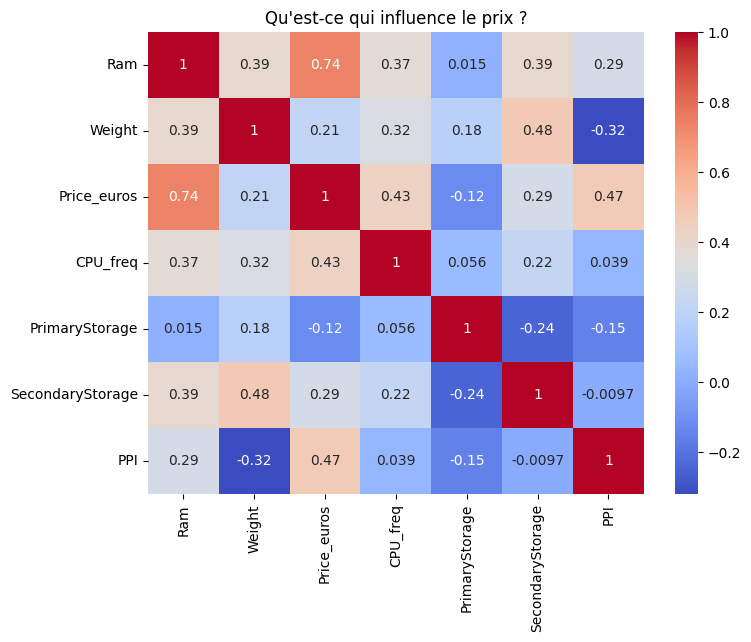

In [11]:
plt.figure(figsize=(8, 6))

numeric_df = df_reg.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Qu'est-ce qui influence le prix ?")
plt.show()

In [12]:
# Encodage
df_encoded = pd.get_dummies(df_reg, drop_first=True)

print(f"Nombre de colonnes après encodage : {df_encoded.shape[1]}")

Nombre de colonnes après encodage : 253


In [13]:
X = df_encoded.drop(columns=['Price_euros'])

y = np.log1p(df_encoded['Price_euros'])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print(f"Train shape : {X_train.shape}")
print(f"Test shape  : {X_test.shape}")

Train shape : (1083, 252)
Test shape  : (192, 252)


In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

r2_lr = r2_score(y_test, lr.predict(X_test))
print(f" Score R² (Linéaire) : {r2_lr:.4f}")

 Score R² (Linéaire) : 0.8366


In [16]:
# Entraînement avec alpha=10 (pénalité)
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)

r2_ridge = r2_score(y_test, ridge.predict(X_test))
print(f" Score R² (Ridge)    : {r2_ridge:.4f}")

 Score R² (Ridge)    : 0.8341


In [17]:
#  Recherche du meilleur Alpha 

alphas = [0.001, 0.01, 0.1, 1, 5, 10, 20, 50, 100]
best_score = 0
best_alpha = 0

for a in alphas:
    r = Ridge(alpha=a)
    r.fit(X_train, y_train)
    
    score = r2_score(y_test, r.predict(X_test))
    
    if score > best_score:
        best_score = score
        best_alpha = a

print(f" Le meilleur Alpha est : {best_alpha}")
print(f" Nouveau Score R² optimisé : {best_score:.4f}")

best_model = Ridge(alpha=best_alpha)
best_model.fit(X_train, y_train)

 Le meilleur Alpha est : 1
 Nouveau Score R² optimisé : 0.8541


,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gradient.",None


In [18]:
final_model = best_model

print(" Le modèle Ridge Optimisé est sélectionné pour la suite.")

 Le modèle Ridge Optimisé est sélectionné pour la suite.


In [19]:
y_pred_log = final_model.predict(X_test)

# 2. On inverse le Log (Exponentielle) pour avoir des Euros
y_pred_euros = np.expm1(y_pred_log)
y_test_euros = np.expm1(y_test)

# 3. Calcul de l'erreur
mae = mean_absolute_error(y_test_euros, y_pred_euros)

print(f" Erreur Moyenne par ordinateur : {mae:.0f} €")

 Erreur Moyenne par ordinateur : 199 €


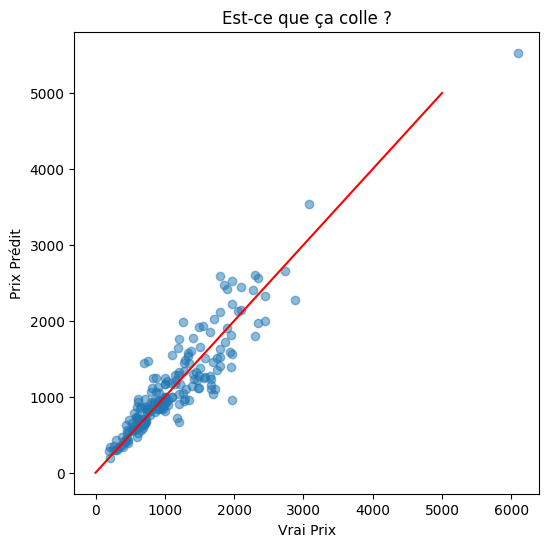

In [20]:
plt.figure(figsize=(6, 6))

# Les points bleus (Prédictions)
plt.scatter(y_test_euros, y_pred_euros, alpha=0.5)

# La ligne rouge (La perfection)
plt.plot([0, 5000], [0, 5000], color='red')

plt.xlabel("Vrai Prix")
plt.ylabel("Prix Prédit")
plt.title("Est-ce que ça colle ?")
plt.show()

In [21]:
import pickle
import os

# Sauvegarde du modèle
pickle.dump(final_model, open('../models/price_model.pkl', 'wb'))

# Sauvegarde des colonnes
pickle.dump(list(X.columns), open('../models/price_columns.pkl', 'wb'))